In [30]:
import json
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import geometry
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from utils.utils import load_sfkb ,get_image_ids, transform_utm_buildings
import os
import PIL
import sys
from cv2 import resize
import cogdumper
import glob

buildings = load_sfkb(max_buildings=1000)
buildings = get_image_ids(buildings)
buildings = transform_utm_buildings(buildings)
#dump_building_objects(buildings, '../results/building_objects')


KeyboardInterrupt: 

In [ ]:
def dump_cutouts_and_objects(buildings, image_ids,cutout_path='../results/cutouts', object_path='../results/objects', nudge=np.array((13,20)), pad=15, image_size=256):
    '''
    Extracts building cutouts from an list of aerial images referenced by the name of the image file.
    Assumes pointer dictionary at ../results/image_to_building_pointers.pickle, 
    aerial photos in ../data/aerial_photos/RGB/ and building objects in ../results/building_objects.
    dumps images at the path given in the keyword argument

    '''

    if not os.path.exists(cutout_path):
        os.makedirs(cutout_path)

    if not os.path.exists(object_path):
        os.makedirs(object_path)

    for image_id in image_ids:
        aerial_photo = plt.imread(f'../data/aerial_photos/RGB/{image_id}.tif')
        for i, building in enumerate(buildings):
            if image_id in building.image_corners.keys():
                corners = building.image_corners[image_id]
                    

                loc_min = np.min(corners, axis=0).astype(int) 
                loc_max = np.max(corners, axis=0).astype(int)
                
                x_ext, y_ext = loc_max[0]-loc_min[0], loc_max[1]-loc_min[1]

                if x_ext > y_ext: # Pad shortest axis
                    sq_pad = np.array((0, (x_ext-y_ext)/2)).astype(int)
                else:
                    sq_pad = np.array(((y_ext-x_ext)/2, 0)).astype(int)

                if x_ext != 0 and y_ext != 0:
                    im =  aerial_photo[loc_min[1]-pad-sq_pad[1]:loc_max[1]+2*pad +sq_pad[1]+ nudge[1], loc_min[0]-pad - sq_pad[0]:loc_max[0]+2*pad + nudge[0]+sq_pad[0]] # crop cutout
                else:
                    pass
                    
                graph_cutout = ((corners.T-loc_min.reshape(-1, 1)+pad+nudge.reshape(-1, 1) + sq_pad.reshape(-1, 1))*image_size/np.array(im.shape[:2]).reshape(2, 1)).T # transform graph to cutout frame 
                buildings[i].cutout_corners[image_id] = graph_cutout
                
                d_min = np.min(im.shape[:2])
                im = resize(im[:d_min, :d_min], (image_size, image_size))



                plt.imsave(f'{cutout_path}/{building.id}_{image_id}.png', im)
                with open(f'{object_path}/{building.id}.pickle', 'wb') as handle:
                    pickle.dump(building, handle)

        print(f'image {image_id} done')

In [ ]:

ids = [id.split('.')[0] for id in os.listdir('../data/aerial_photos/RGB')[104:109]]

print (ids)

['14525_03_001_00105', '14525_03_002_00106', '14525_03_003_00107', '14525_03_004_00108', '14525_03_005_00109']


In [12]:
dump_cutouts_and_objects(buildings, ids)

image 14525_03_001_00105 done
image 14525_03_002_00106 done
image 14525_03_003_00107 done
image 14525_03_004_00108 done
image 14525_03_005_00109 done


In [13]:
object_path = '../results/objects'
buildings = list()
for filename in os.listdir(object_path):
    with open(f'{object_path}/{filename}', 'rb') as file:
        buildings.append(pickle.load(file))

In [26]:
len(buildings)

49

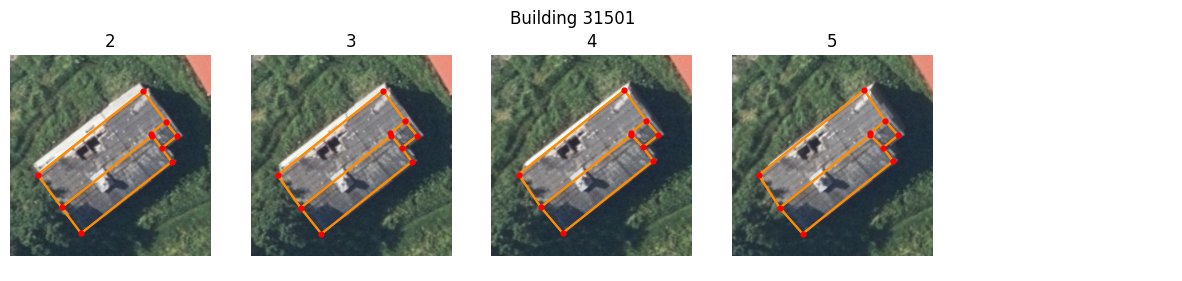

In [29]:
buildings[34].plot_cutout(plot_graph=True)